# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import, division, print_function

import os

!git clone https://github.com/brandleyzhou/DIFFNet.git
os.chdir('DIFFNet')

fatal: destination path 'DIFFNet' already exists and is not an empty directory.


In [39]:
import sys
import glob
import argparse
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from cv2 import imwrite
import networks
from layers import disp_to_depth
from utils import download_model_if_doesnt_exist


In [29]:
!pip install yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setting up network and loading weights

In [34]:
model_name = "diffnet_640x192"

#download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
print("   Loading pretrained encoder")
encoder = networks.test_hr_encoder.hrnet18(False)
encoder.num_ch_enc = [ 64, 18, 36, 72, 144 ]
depth_decoder = networks.HRDepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

   Loading pretrained encoder


## Loading the test image and preporcessing

In [36]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [37]:


with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]



## Plotting

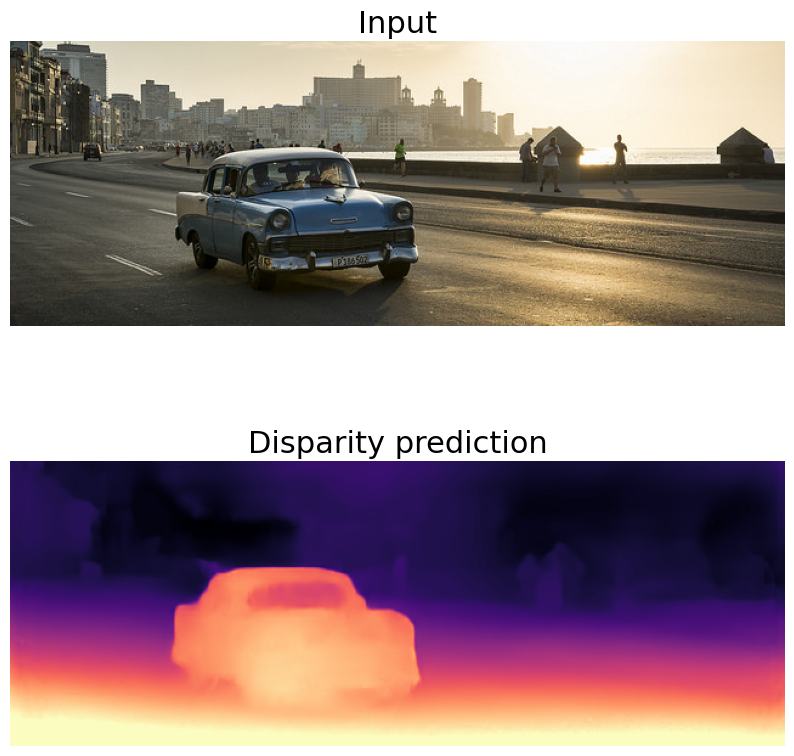

In [40]:


disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

